In [48]:
import csv
import cv2
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
from PIL import Image
import torchvision.models as models
%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [42]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform ): #Normalize to pretrained VGGNet
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        #File with the Path
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=[0],dtype = 'str',nrows = 1000)
        #File with labels
        self.label_frame = pd.read_csv(text_file,sep=",", usecols=[1], nrows = 1000)
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #Pull image
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        
        #Apply adapative threshold to highlight key features in the image   
        image = cv2.imread(img_name,0)
        image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)  
        image = Image.fromarray(image)
        image = image.convert('L')
        
        #Apply tensor transformations to images
        image = self.transform(image) 
        
        # I included labels in the train_image_path file in excel using a find("positive")
        labels = self.label_frame.iloc[idx,0] 
        
        #Formatting for labels
        labels = np.array(labels)
        labels = np.reshape(labels, (1,1))
        labels= torch.from_numpy(labels.astype('int'))

        sample = {'image': image, 'labels': labels}
        
        return sample

In [43]:
MuraTrainSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/Shoulder_Mura.csv',
                           root_dir = '/Users/JosephVele',
                          transform = transforms.Compose([transforms.Resize((224,224)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTrainLoader = torch.utils.data.DataLoader(MuraTrainSet,batch_size=100,shuffle=True, num_workers=0)

MuraTestSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/Shoulder_Mura_test.csv',
                                   root_dir = '/Users/JosephVele')

MuraTestLoader = torch.utils.data.DataLoader(MuraTestSet,batch_size=30,shuffle=False, num_workers=0)

In [49]:
#Calculate mean &std - batch was sent to 8379 to match number of records in one batch

for i_batch,sample_batched in enumerate(MuraTrainLoader,0):
    numpy_image = sample_batched['image'].numpy()
    image_mean = np.mean(numpy_image, axis=(0,2,3))
    image_std = np.std(numpy_image, axis=(0,2,3))


#image_mean=np.mean(x, axis= (0))
#image_std=np.std(x, axis=(0))

In [50]:
#Confirm images have been normalized appropriately with 0 mean and 1 std
#This will help with vanishing gradient problem
print(image_mean)
print(image_std)

[0.02527229]
[0.96729124]


In [2]:

dense_net169 = models.densenet169(pretrained=True)

/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /Users/JosephVele/.torch/models/densenet169-b2777c0a.pth
100.0%


In [32]:
for param in dense_net169.features.parameters():
    param.requires_grad = False
#Adjust to grayscale = 1 channel. Requires gradient is True by default
dense_net169.features._modules['conv0']  = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
dense_net169.classifier = nn.Linear(in_features=1664, out_features=1, bias=True)
#dense_net169

for param in dense_net169.classifier.parameters():
    print(param.size())


torch.Size([1, 1664])
torch.Size([1])


In [44]:
# Define hyper-parameters
#******************************#

learning = 1e-3 # Learning Rate 

w = 1e-2
b = [.9,999]
#******************************#

In [45]:
# 4.1 Define criterion and optimizer
#************************************#
import torch.optim as optim


criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(dense_net169.classifier.parameters(), lr=learning, weight_decay = w)

#************************************#

# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

train_losses = []
test_losses = []
acc_data_train=[]
acc_data_test=[]


def train(epoch):
    dense_net169.train()
    train_loss = 0
    correct = 0
    for i, sample_batched in enumerate(MuraTrainLoader,1):
        inputs = sample_batched['image']
        labels = sample_batched['labels']
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = dense_net169(inputs)
        labels = labels.view(len(sample_batched['labels']),-1)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
        
        pred = (torch.sigmoid(outputs).data > 0.5).int()
        labels = labels.int()
        correct += pred.eq(labels.data.view_as(pred)).sum()


    
    #Print Results from first Epoch
    #Accuracy
    acc =  100.00 * float(correct) / float(len(MuraTrainLoader.dataset))
    acc_data_train.append(acc)
    #Average Loss
    train_loss=float(train_loss)/float(i)
    train_losses.append(train_loss)
    # print statistics        
    print('Train Epoch:{} Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            train_loss, correct, len(MuraTrainLoader.dataset), acc))

def test(epoch):
    #Have our model in evaluation mode
    dense_net169.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraTestLoader,1):
            inputs = sample_batched['image']
            labels = sample_batched['labels']
            outputs = dense_net169(inputs)
            labels = labels.view(len(sample_batched['labels']),-1)
            loss = criterion(outputs.float(), labels.float())
            test_loss += loss.item()

            pred = (torch.sigmoid(outputs).data > 0.5).int()
            labels = labels.int()
            correct += pred.eq(labels.data.view_as(pred)).sum()

        test_loss = test_loss/i
        test_losses.append(test_loss)
        
        acc =  100.00 * float(correct) / float(len(MuraTestLoader.dataset))
        acc_data_test.append(acc)
        print('Test Epoch:{} Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
            test_loss, correct, len(MuraTestLoader.dataset),
            acc))

In [ ]:
#Train + Test per epoch
for epoch in range(1,10): 
    train(epoch)
    test(epoch)

Train Epoch:1 Loss: 0.6220, Accuracy: 662/1000 (66.20%)

Test Epoch:1 Loss: 0.6629, Accuracy: 347/562 (61.74%)

Train Epoch:2 Loss: 0.6089, Accuracy: 697/1000 (69.70%)

Test Epoch:2 Loss: 0.6609, Accuracy: 344/562 (61.21%)

Train Epoch:3 Loss: 0.6054, Accuracy: 696/1000 (69.60%)

Test Epoch:3 Loss: 0.6671, Accuracy: 340/562 (60.50%)

Train Epoch:4 Loss: 0.5878, Accuracy: 704/1000 (70.40%)

Test Epoch:4 Loss: 0.6670, Accuracy: 332/562 (59.07%)

Train Epoch:5 Loss: 0.5859, Accuracy: 710/1000 (71.00%)

Test Epoch:5 Loss: 0.6675, Accuracy: 333/562 (59.25%)

Train Epoch:6 Loss: 0.5757, Accuracy: 729/1000 (72.90%)

Test Epoch:6 Loss: 0.6538, Accuracy: 354/562 (62.99%)

Train Epoch:7 Loss: 0.5683, Accuracy: 744/1000 (74.40%)

Test Epoch:7 Loss: 0.6575, Accuracy: 351/562 (62.46%)

Train Epoch:8 Loss: 0.5651, Accuracy: 736/1000 (73.60%)

Test Epoch:8 Loss: 0.6579, Accuracy: 353/562 (62.81%)

Train Epoch:9 Loss: 0.5553, Accuracy: 740/1000 (74.00%)

Test Epoch:9 Loss: 0.6541, Accuracy: 360/562 (6

# Alex Net on Body Part Images

In [63]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,text_file,root_dir, transform ): #Normalize to pretrained VGGNet
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        #File with the Path
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=[0],dtype = 'str')
        #File with labels
        self.label_frame = pd.read_csv(text_file,sep=",")
        self.root_dir = root_dir
        self.transform = transform
                                       
    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, idx):
        #Pull image
        img_name = os.path.join(self.root_dir, self.name_frame.iloc[idx, 0])
        
        #Apply adapative threshold to highlight key features in the image   
        image = cv2.imread(img_name,0)
        image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)  
        image = Image.fromarray(image)
        image = image.convert('L')
        
        #Apply tensor transformations to images
        image = self.transform(image) 
        
        # I included labels in the train_image_path file in excel using a find("positive")
        labels = self.label_frame.iloc[idx,10]
        labels = np.array(labels)

        #Formatting for labels
        labels = np.array(labels)
        labels= torch.from_numpy(labels.astype('int64'))

        sample = {'image': image, 'labels': labels}
        
        return sample

In [108]:
MuraTrainSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/train_image_paths.csv',
                           root_dir = '/Users/JosephVele',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTrainLoader = torch.utils.data.DataLoader(MuraTrainSet,batch_size=100,shuffle=True, num_workers=0)

MuraTestSet = MuraDataset(text_file ='/Users/JosephVele/MURA-v1.1/valid_image_paths.csv',
                           root_dir = '/Users/JosephVele',
                          transform = transforms.Compose([transforms.Resize((227,227)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(
                                                              mean=[0.456],
                                                              std= [0.225])]))

MuraTestLoader = torch.utils.data.DataLoader(MuraTestSet,batch_size=100,shuffle=True, num_workers=0)



In [81]:
alex_net = models.alexnet(pretrained=True)
for param in alex_net.parameters():
    param.requires_grad = False
#Adjust Model can read gray scale images
alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#Adjust Output
alex_net.classifier._modules['6'] = nn.Linear(4096, 7)


In [91]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_net.parameters(), lr=.01)

#************************************#

# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

train_losses = []
test_losses = []
acc_data_train=[]
acc_data_test=[]

def alex_train(epoch, max_batch):
    alex_net.train()
    train_loss = 0
    correct = 0
    for i, sample_batched in enumerate(MuraTrainLoader,1):
        if i <max_batch:
            inputs = sample_batched['image']
            labels = sample_batched['labels']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
        else:
            break
    
    accuracy = float(100*float(correct)/(len(inputs)*max_batch))

    acc_data_train.append([accuracy])
    train_loss=float(train_loss)/float(i)
    train_losses.append(train_loss)
    # print statistics        
    print('Train Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
          format(epoch, correct,(len(inputs)*max_batch), accuracy, train_loss))

In [123]:
#Hyperparameter tuning - Grid Search 
learning_rates = [.1,.01,.001, .00001]
momentums = [.3,.4,.5,.6, .7, .8, .9]
w = [.1,.01,.001]

for i in [1,2]: #Test different optimizer
    for j in range(len(learning_rates)):    
        if i ==1:
            for k in range(len(momentums)):
                #Reset Model per test
                alex_net = models.alexnet(pretrained=True)
                for param in alex_net.parameters():
                    param.requires_grad = False
                alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
                #Adjust Output
                alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
                
                optimizer = optim.SGD(alex_net.parameters(), 
                                  lr=learning_rates[j], momentum=momentums[k])
                criterion = nn.CrossEntropyLoss()
                
                print('Optimizer: SGD\tLearning Rate: {}\tMomentum: {}'.
                      format (learning_rates[j], momentums[k]))
                alex_train(1,20)
                
        else: 
            for k in range(len(w)):
                #Reset Model per test
                alex_net = models.alexnet(pretrained=True)
                for param in alex_net.parameters():
                    param.requires_grad = False
                    
                alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
                #Adjust Output
                alex_net.classifier._modules['6'] = nn.Linear(4096, 7)
                
                optimizer = optim.Adam(alex_net.parameters(), 
                                       lr=learning_rates[j], weight_decay = w[k], amsgrad=True)
                criterion = nn.CrossEntropyLoss()
        
                print('Optimizer: Adam\t Learning Rate: {}\t WeightDecay: {}'.
                      format (learning_rates[j], w[k]))
                alex_train(1,20)

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.3
Train Epoch:7  Accuracy: (393/2000) 19.65%   Average Loss: 28.09 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.4
Train Epoch:7  Accuracy: (391/2000) 19.55%   Average Loss: 10790.84 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.5
Train Epoch:7  Accuracy: (364/2000) 18.20%   Average Loss: 17635.25 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.6
Train Epoch:7  Accuracy: (373/2000) 18.65%   Average Loss: 11194.87 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.7
Train Epoch:7  Accuracy: (366/2000) 18.30%   Average Loss: 6271.56 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.8
Train Epoch:7  Accuracy: (391/2000) 19.55%   Average Loss: 69021.08 

Optimizer: SGD	Learning Rate: 0.1	Momentum: 0.9
Train Epoch:7  Accuracy: (327/2000) 16.35%   Average Loss: 1736027.30 

Optimizer: SGD	Learning Rate: 0.01	Momentum: 0.3
Train Epoch:7  Accuracy: (675/2000) 33.75%   Average Loss: 1.59 

Optimizer: SGD	Learning Rate: 0.01	Momentum: 0.4
Train Epoch:

In [130]:
alex_net = models.alexnet(pretrained=True)
for param in alex_net.parameters():
    param.requires_grad = False
alex_net.features._modules['0'] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#Adjust Output
alex_net.classifier._modules['6'] = nn.Linear(4096, 7)

optimizer = optim.Adam(alex_net.parameters(), 
                                       lr=.001, weight_decay = .01, amsgrad=True)
criterion = nn.CrossEntropyLoss()

train_losses = []
acc_data_train=[]


In [132]:
for epoch in range(1,21):
    alex_train(epoch,100)

Train Epoch:1  Accuracy: (5914/10000) 59.14%   Average Loss: 1.17 

Train Epoch:2  Accuracy: (7571/10000) 75.71%   Average Loss: 0.70 

Train Epoch:3  Accuracy: (7943/10000) 79.43%   Average Loss: 0.59 

Train Epoch:4  Accuracy: (8225/10000) 82.25%   Average Loss: 0.51 

Train Epoch:5  Accuracy: (8373/10000) 83.73%   Average Loss: 0.46 

Train Epoch:6  Accuracy: (8583/10000) 85.83%   Average Loss: 0.41 

Train Epoch:7  Accuracy: (8713/10000) 87.13%   Average Loss: 0.36 

Train Epoch:8  Accuracy: (8814/10000) 88.14%   Average Loss: 0.34 

Train Epoch:9  Accuracy: (8875/10000) 88.75%   Average Loss: 0.32 

Train Epoch:10  Accuracy: (8902/10000) 89.02%   Average Loss: 0.31 

Train Epoch:11  Accuracy: (8993/10000) 89.93%   Average Loss: 0.28 

Train Epoch:12  Accuracy: (9054/10000) 90.54%   Average Loss: 0.27 

Train Epoch:13  Accuracy: (9113/10000) 91.13%   Average Loss: 0.25 

Train Epoch:14  Accuracy: (9109/10000) 91.09%   Average Loss: 0.25 

Train Epoch:15  Accuracy: (9136/10000) 91.3

Number of Model Parameters:  57017031


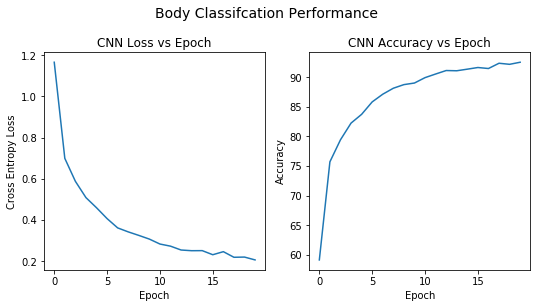

In [140]:
#************************************#
total_params = sum(p.numel() for p in alex_net.parameters())
print('Number of Model Parameters: ', total_params)
#************************************#

body_losses = train_losses
body_accuracy = acc_data_train

# 5.2 Summarize history for loss and make loss vs.epoch plot
#************************************#
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(body_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_title('CNN Loss vs Epoch')
ax2.plot(body_accuracy)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.subplots_adjust(right=1.25)
ax2.set_title('CNN Accuracy vs Epoch')

fig.text(0.64, 1,'Body Classifcation Performance',ha='center', fontsize=14)

plt.show()

In [134]:
test_losses = []
acc_data_test=[]

def alex_test(epoch):
    #Have our model in evaluation mode
    alex_net.eval()
    #Set losses and Correct labels to zero
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, sample_batched in enumerate(MuraTestLoader,1):

            inputs = sample_batched['image']
            labels = sample_batched['labels']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = alex_net(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            test_loss+= loss.item()
            pred = outputs.data.max(1, keepdim=True)[1].int()
            #print(pred)
            labels = labels.int()
            #print(labels)

            correct += pred.eq(labels.data.view_as(pred)).sum()
             
    
        accuracy = float(100*float(correct)/(len(MuraTestLoader.dataset)))

        acc_data_test.append([accuracy])
        test_loss=float(test_loss)/float(i)
        test_losses.append(test_loss)
        # print statistics        
        print('Test Epoch:{}  Accuracy: ({}/{}) {:.2f}%   Average Loss: {:.2f} \n'.
              format(epoch, correct,len(MuraTestLoader.dataset), accuracy, test_loss))

In [135]:
alex_test(1)

Test Epoch:1  Accuracy: (2909/3196) 91.02%   Average Loss: 0.29 

